In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (classification_report,accuracy_score,
                             confusion_matrix, roc_auc_score,
                             roc_curve, auc)

import joblib

# Load Data

In [2]:
data = pd.read_csv('diabetes_synthetic_final.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,ethnicity_Other,ethnicity_White,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Current,smoking_status_Former,smoking_status_Never,diagnosed_diabetes
0,0.709543,-0.057942,-0.225826,0.950676,0.752379,-0.437071,-1.094334,-1.235246,0.154083,0.938956,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.218520,-0.965856,-0.052990,-1.173118,0.429168,-0.341085,-0.554244,-0.470070,0.502759,0.938956,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.108829,0.849972,-0.329528,0.685201,0.752379,0.666765,-1.870714,-1.745363,-0.717608,-0.486917,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.354340,-0.057942,0.206264,0.751570,0.536905,1.674614,-0.216688,0.040047,0.938604,0.083432,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,-0.108829,-0.057942,-0.882604,0.021516,1.183326,-0.005135,-1.229357,-1.745363,0.938604,-0.629504,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
y = data['diagnosed_diabetes']
x = data.drop('diagnosed_diabetes', axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# 1. LogisticRegression (Baseline)

In [17]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [18]:
y_pred_lr = LR_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_lr))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_lr))

Accuracy score =  0.65888125
Classification report = 
               precision    recall  f1-score   support

         0.0       0.59      0.32      0.42     60575
         1.0       0.68      0.86      0.76     99425

    accuracy                           0.66    160000
   macro avg       0.63      0.59      0.59    160000
weighted avg       0.64      0.66      0.63    160000



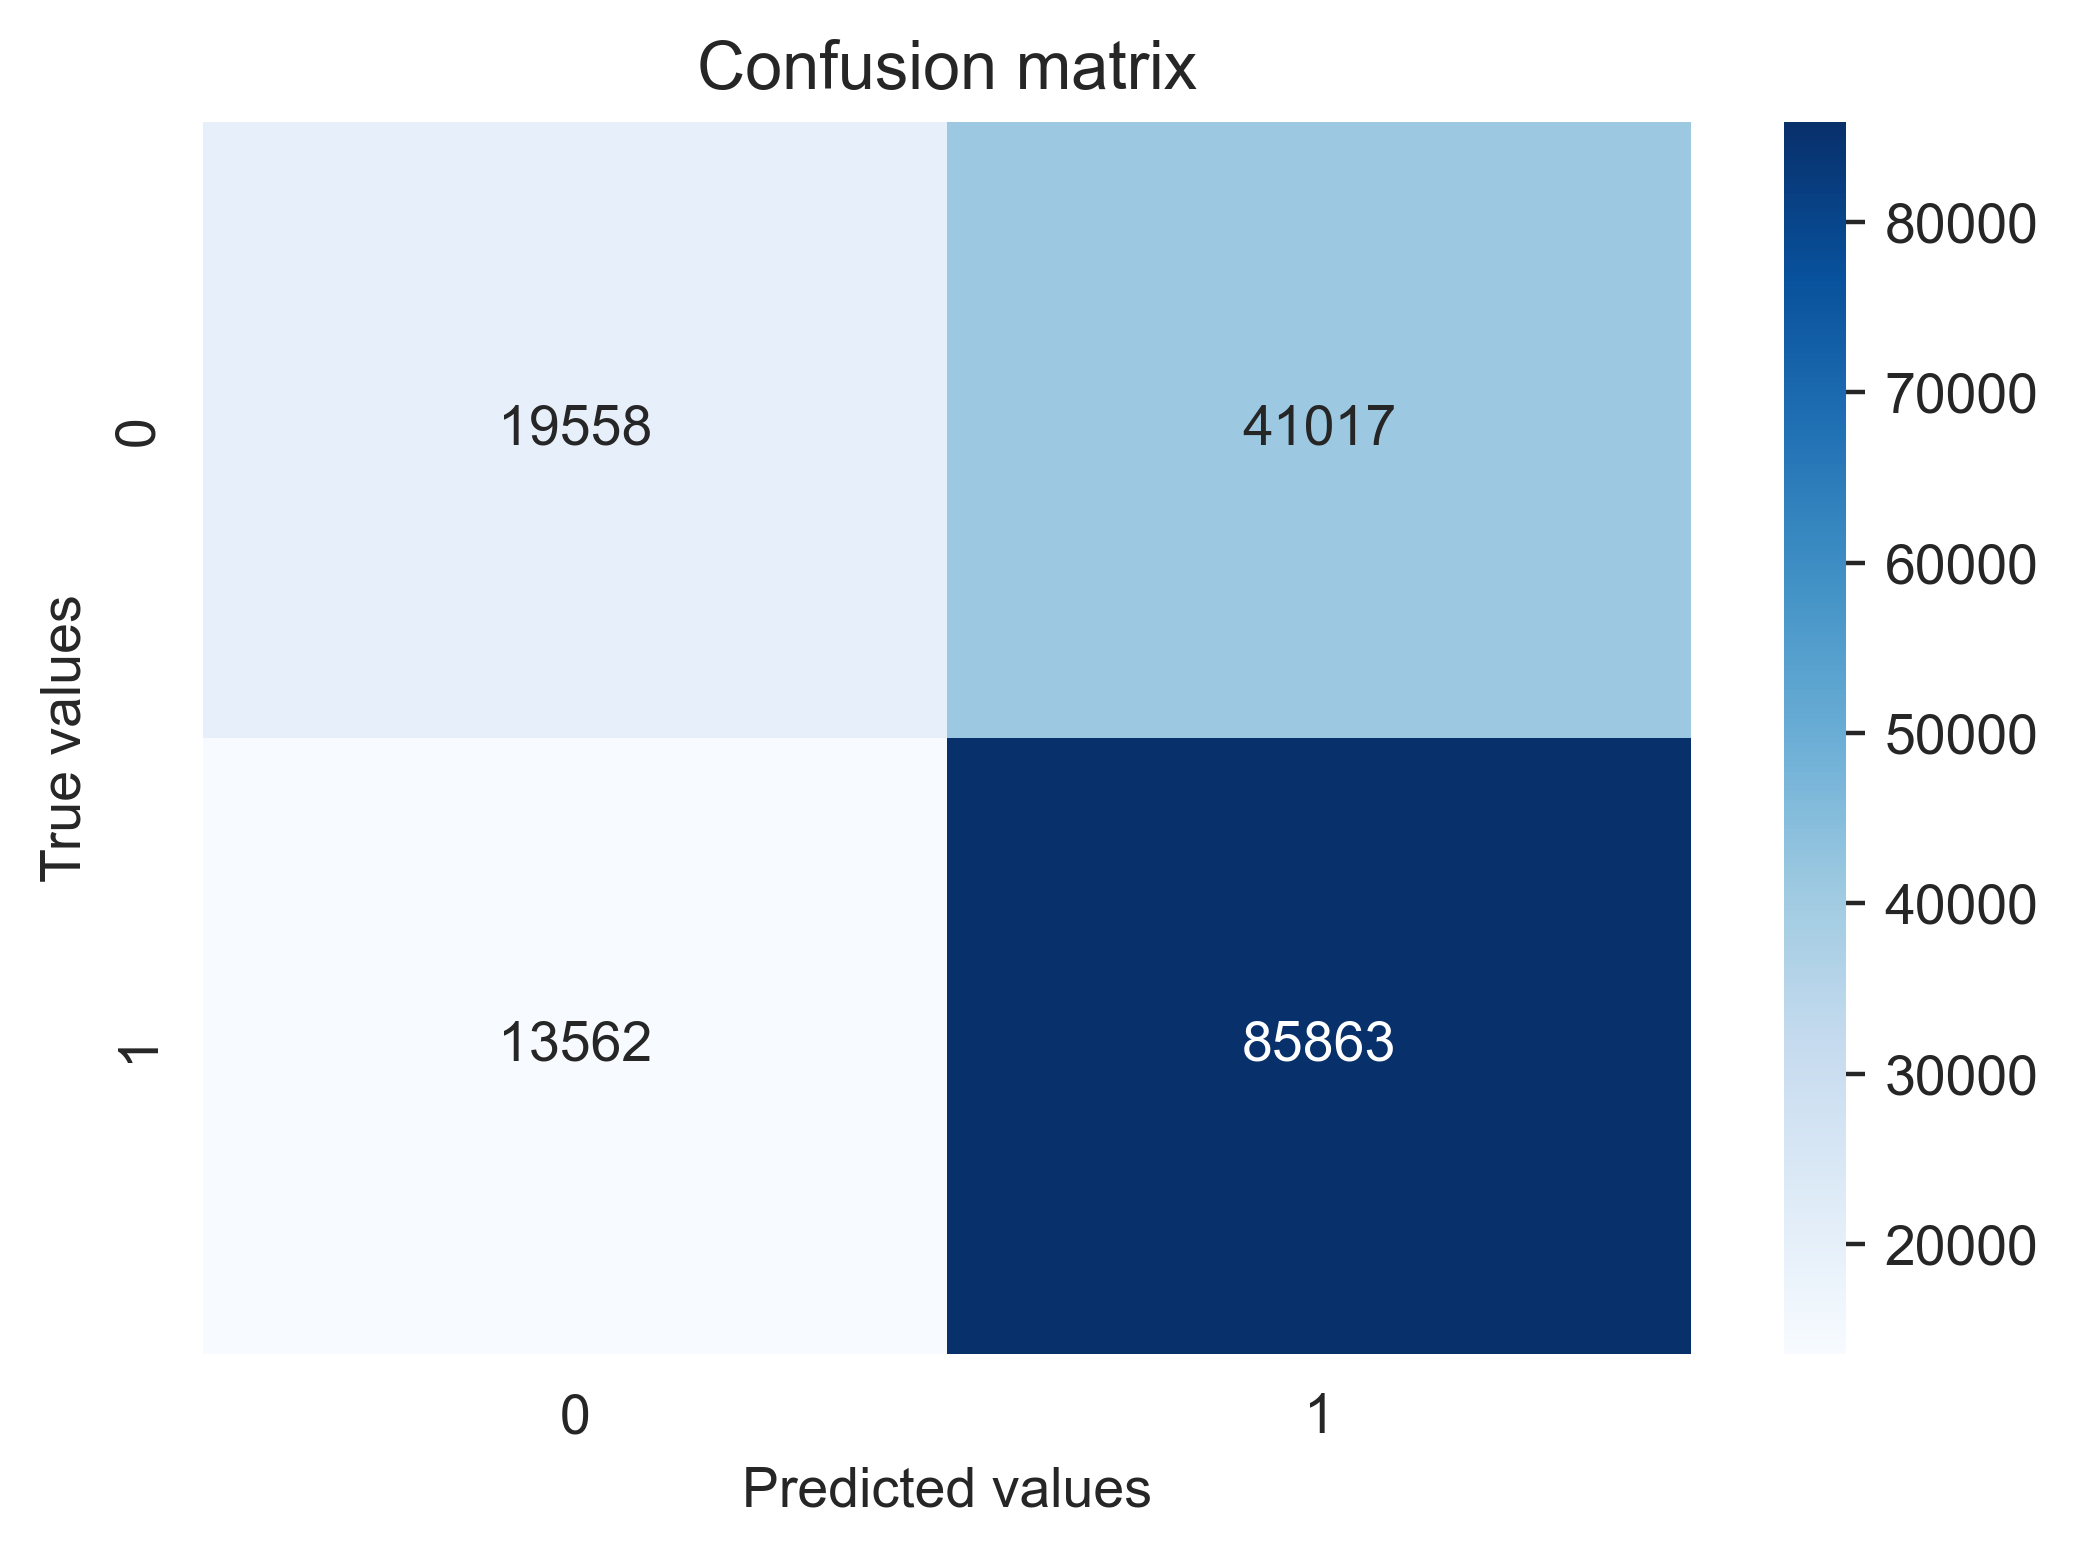

In [19]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [20]:
lr_probs = LR_model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print(f"LogisticRegression AUC Score: {lr_auc:.4f}")

LogisticRegression AUC Score: 0.6886


In [21]:
lr_probs

array([0.34165794, 0.71154495, 0.68246057, ..., 0.48665835, 0.65524113,
       0.57952408])

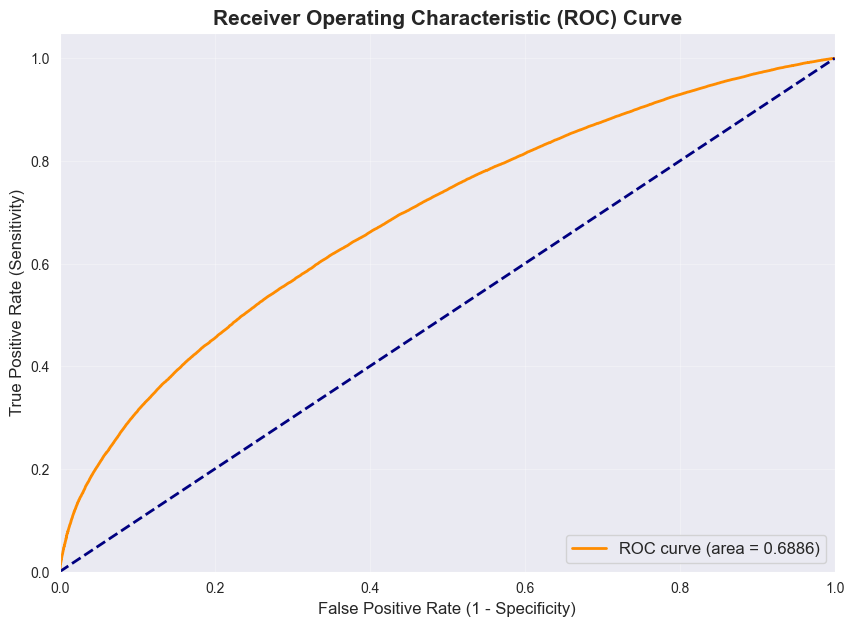

In [22]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# 2. XGBoost

In [17]:
XGB = XGBClassifier(random_state=42, device='gpu')
param = {
    'n_estimators': [200, 600, 1000],       # عدد الأشجار
    'learning_rate': [0.01, 0.05, 0.1],                # سرعة التعلم
    'max_depth': [4, 6, 8],                           # عمق الشجرة
}

grid = GridSearchCV(XGB, param, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:",  grid.best_score_)

KeyboardInterrupt: 

In [11]:
XGB_model = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=4, random_state=42, device='gpu')
XGB_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'gpu'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
y_pred_xgb = XGB_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_xgb))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_xgb))

Accuracy score =  0.6562125
Classification report = 
               precision    recall  f1-score   support

         0.0       0.61      0.25      0.36     60575
         1.0       0.66      0.90      0.77     99425

    accuracy                           0.66    160000
   macro avg       0.64      0.58      0.56    160000
weighted avg       0.64      0.66      0.61    160000



C:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:729: UserWarning: [02:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


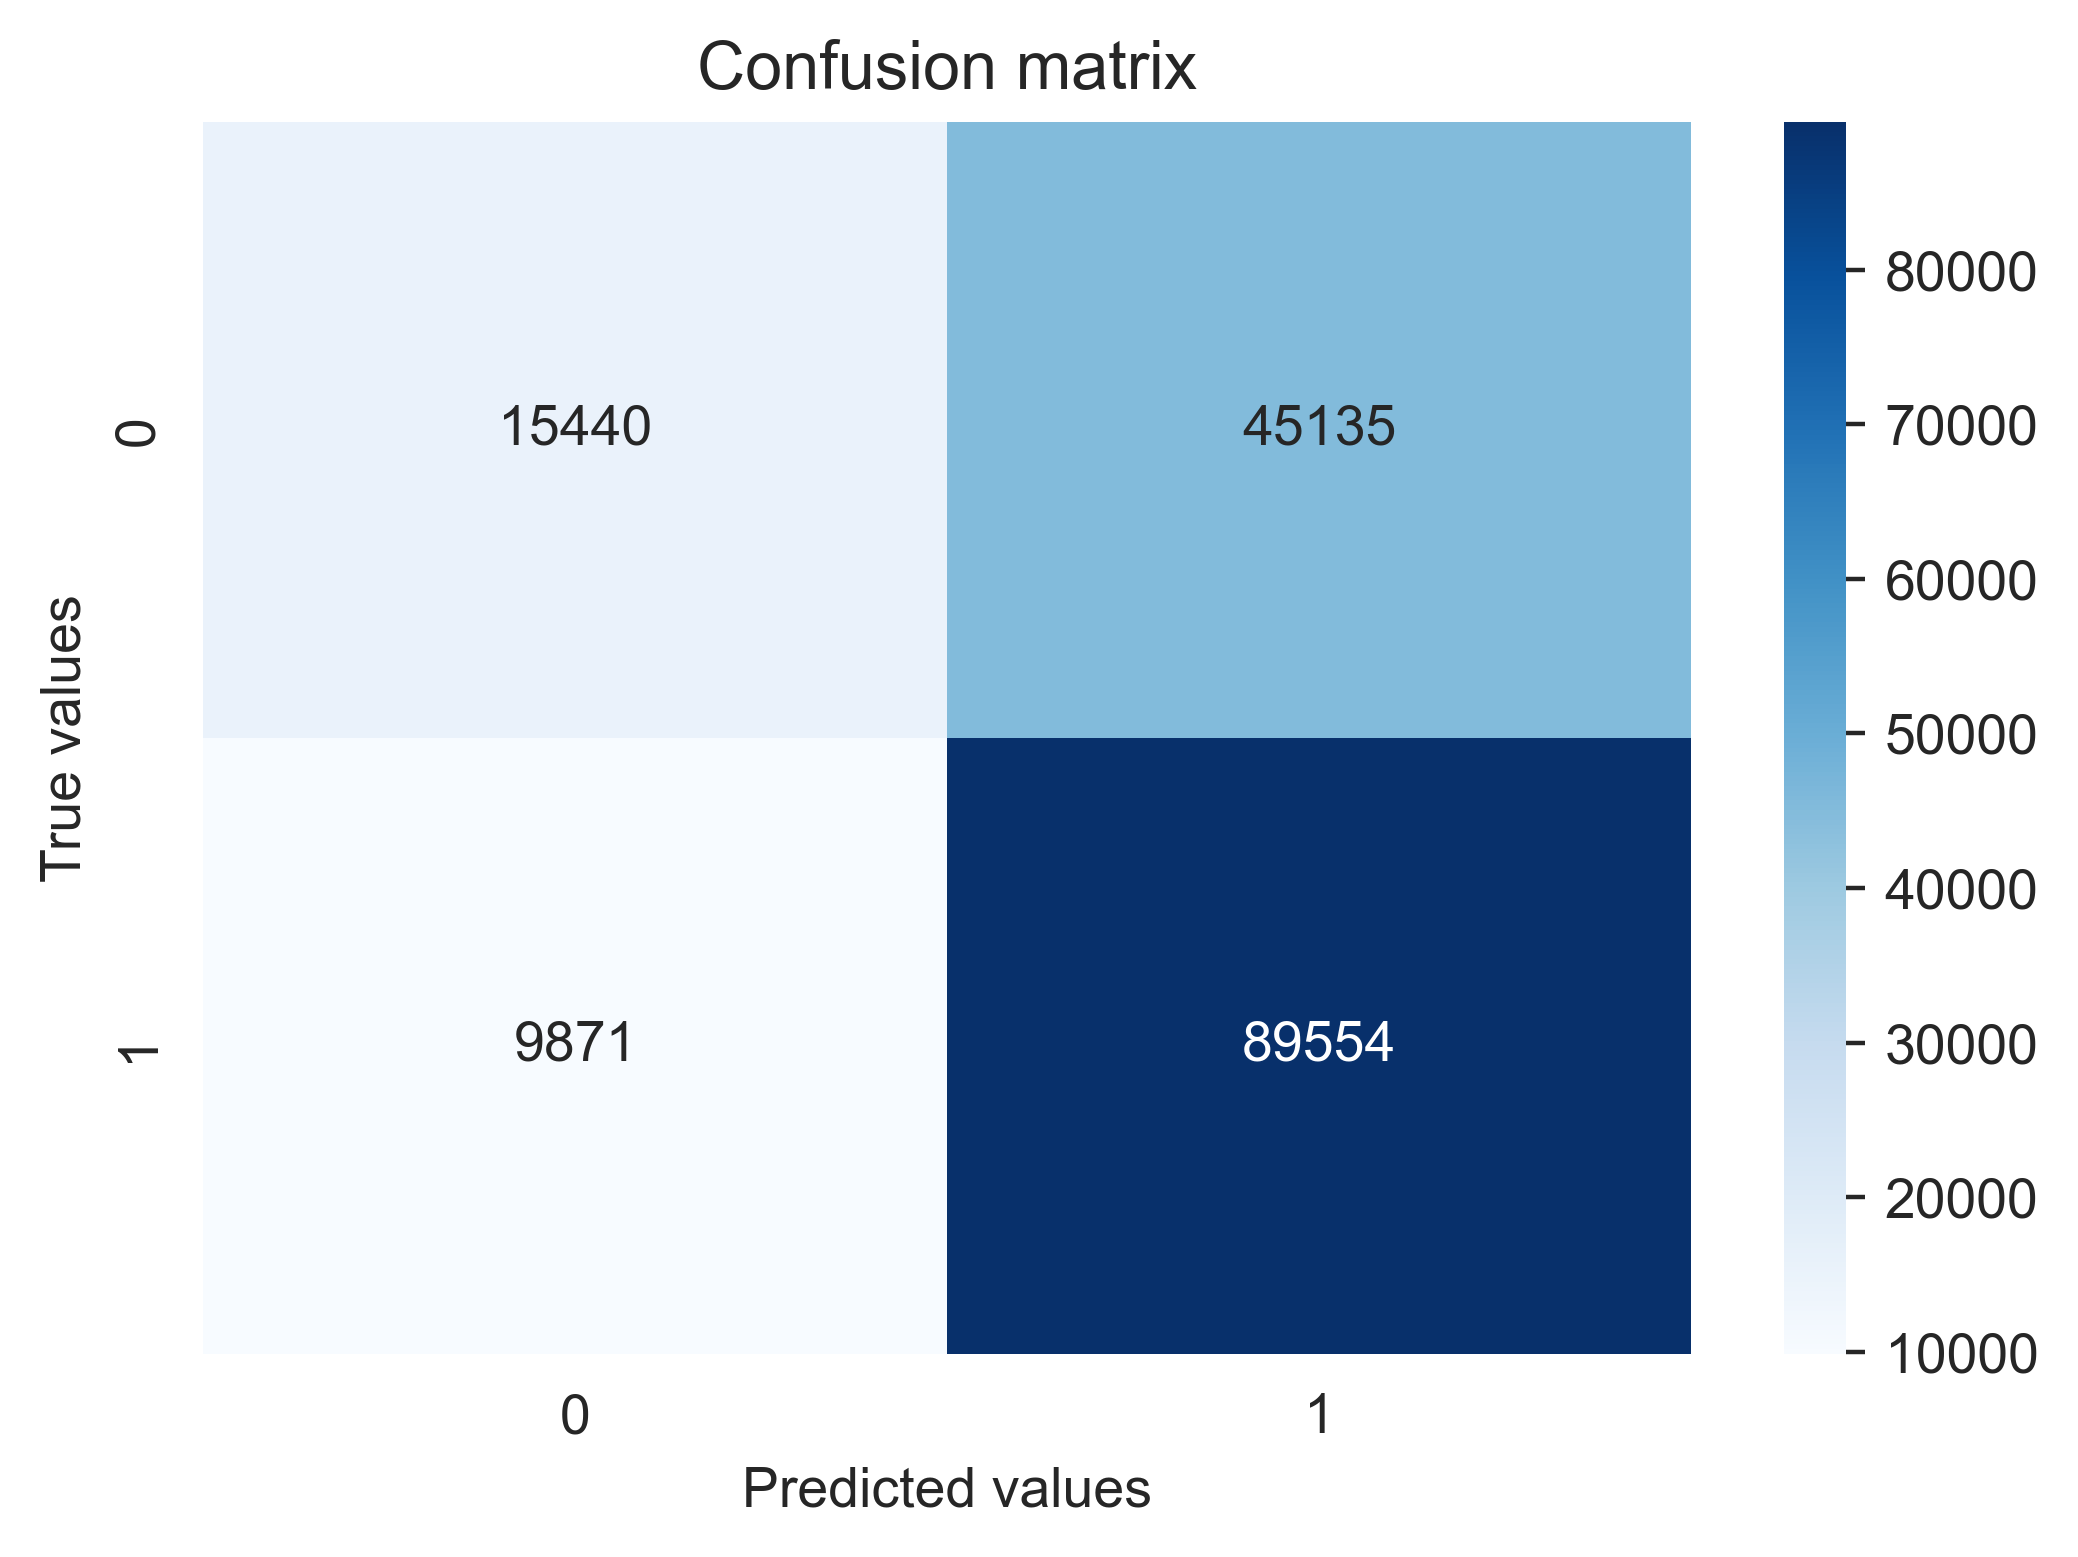

In [13]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [14]:
xgb_probs = XGB_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
print(f"XGBClassifier AUC Score: {xgb_auc:.4f}")

XGBClassifier AUC Score: 0.6890


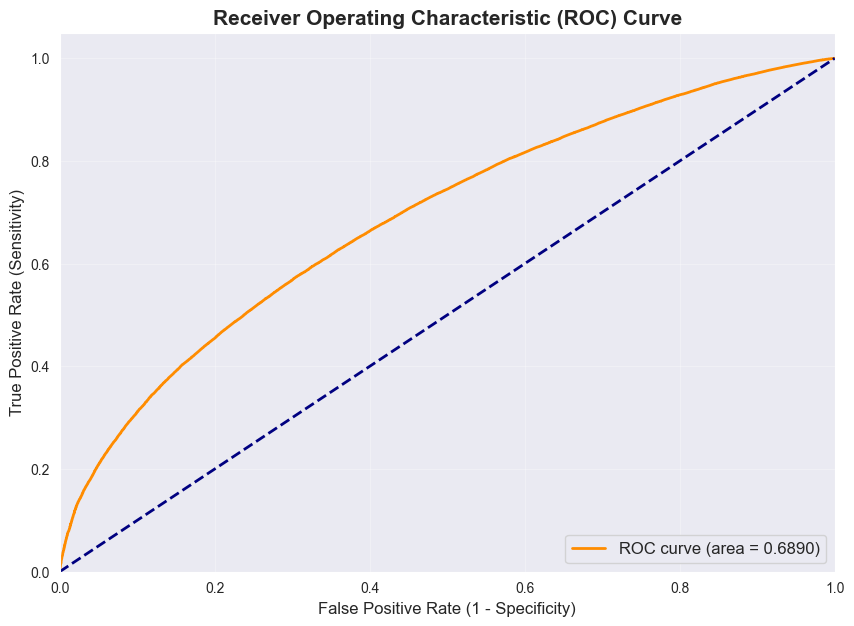

In [15]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# 3. LightGBM

In [23]:
LGM = LGBMClassifier(random_state=42, device='gpu')
param = {
    'n_estimators': [200, 600, 1000],       # عدد الأشجار
    'learning_rate': [0.01, 0.05, 0.1],                # سرعة التعلم
    'num_leaves': [11, 21, 31],                           # عمق الشجرة
}

grid = GridSearchCV(LGM, param, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:",  grid.best_score_)

KeyboardInterrupt: 

In [5]:
LGBM_model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=8,
    random_state=42,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    importance_type='gain',
    n_jobs=-1
)
LGBM_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 396880, number of negative: 243120
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 35
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (12.21 MB) transferred to GPU in 0.022518 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620125 -> initscore=0.490079
[LightGBM] [Info] Start training from score 0.490079


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,8
,learning_rate,0.01
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [6]:
y_pred_lgbm = LGBM_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_lgbm))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_lgbm))


Accuracy score =  0.67613125
Classification report = 
               precision    recall  f1-score   support

         0.0       0.61      0.41      0.49     60575
         1.0       0.70      0.84      0.76     99425

    accuracy                           0.68    160000
   macro avg       0.65      0.62      0.63    160000
weighted avg       0.66      0.68      0.66    160000



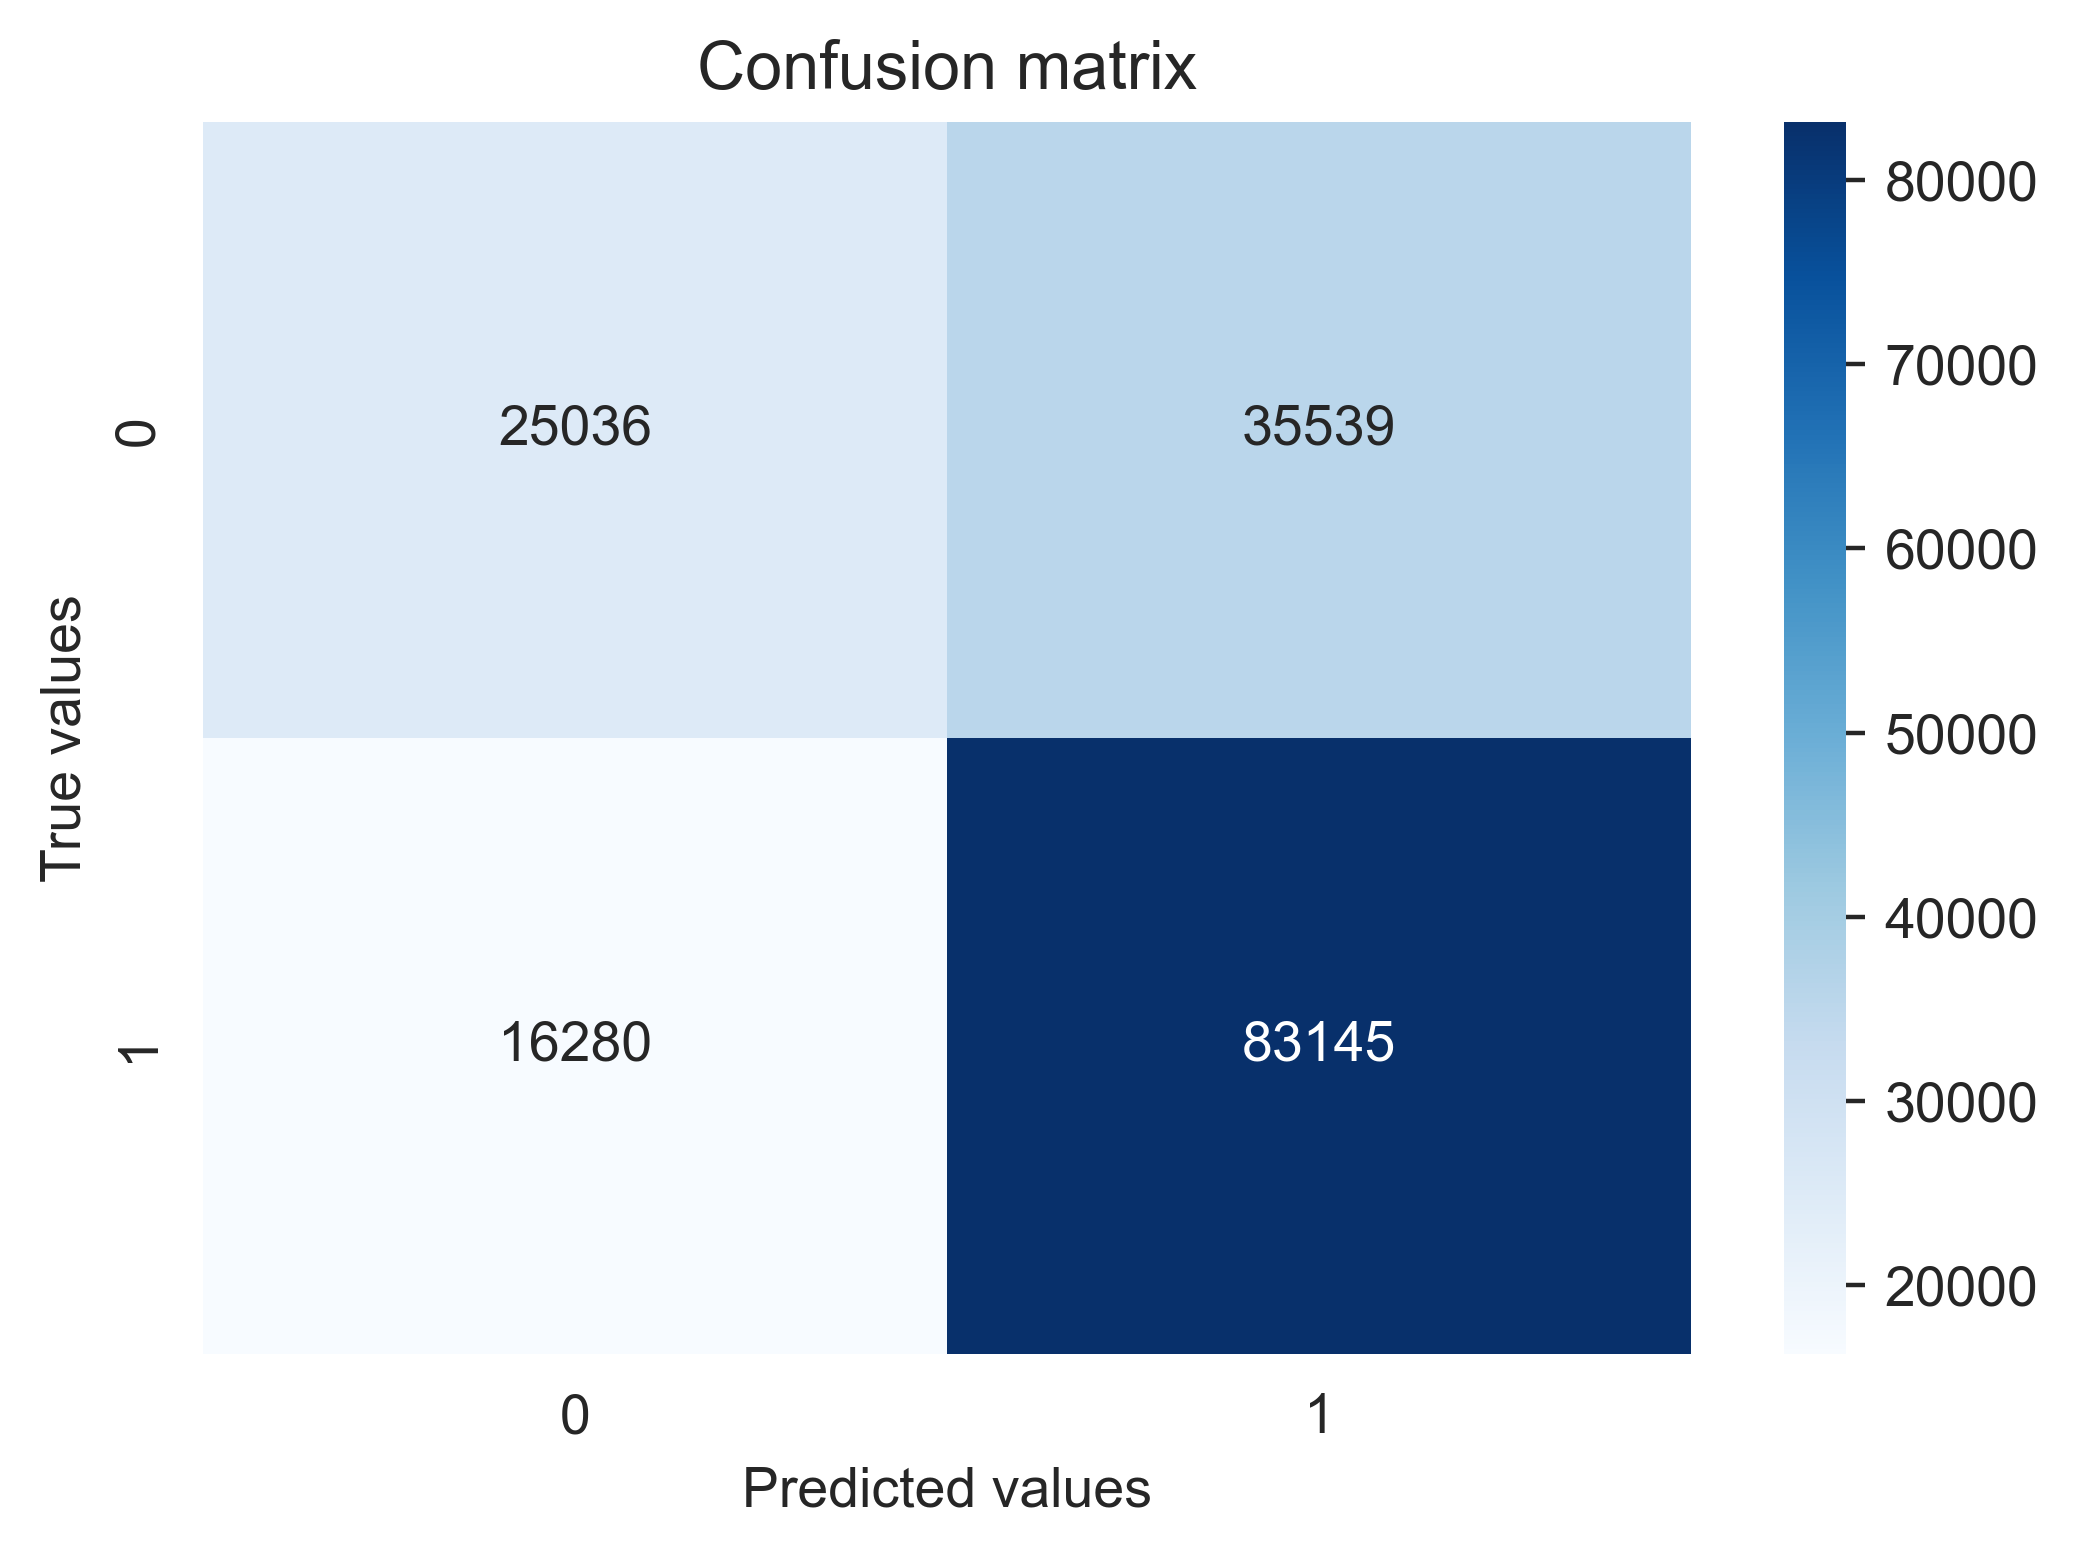

In [7]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [8]:
lgbm_probs = LGBM_model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
print(f"LGBMClassifier AUC Score: {lgbm_auc:.4f}")

LGBMClassifier AUC Score: 0.7148


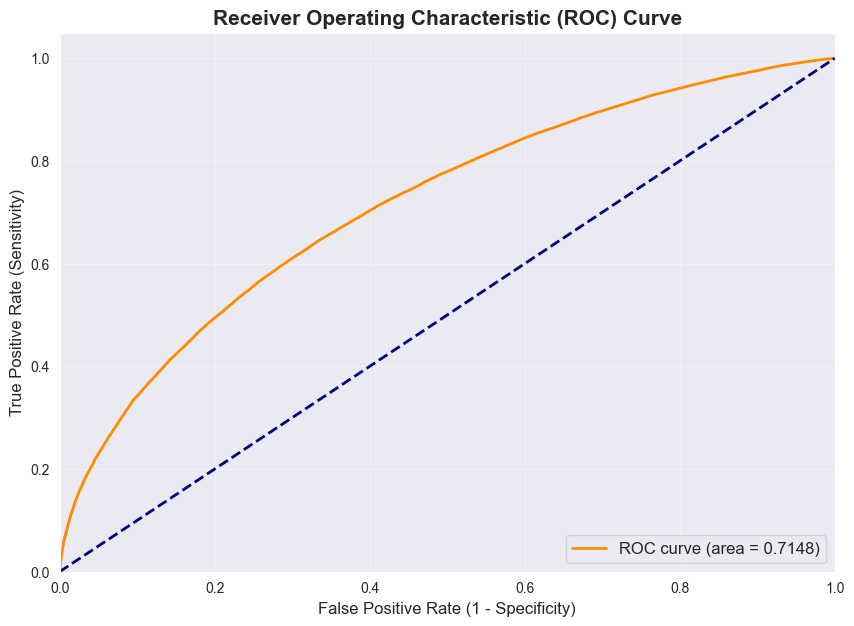

In [9]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, lgbm_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# 4. CatBoostClassifier

In [27]:
cat_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    task_type="GPU",       # ضروري جداً لتسريع التدريب
    devices='0',           # استخدام الـ GPU المتاح
    verbose=100,           # يطبع النتائج كل 100 خطوة
    random_seed=42
)
cat_model.fit(X_train, y_train)


0:	learn: 0.6878141	total: 143ms	remaining: 4m 46s
100:	learn: 0.6043294	total: 2.13s	remaining: 40s
200:	learn: 0.5998273	total: 3.87s	remaining: 34.6s
300:	learn: 0.5970612	total: 6.52s	remaining: 36.8s
400:	learn: 0.5948291	total: 8.85s	remaining: 35.3s
500:	learn: 0.5929780	total: 10.7s	remaining: 32s
600:	learn: 0.5914657	total: 13.9s	remaining: 32.3s
700:	learn: 0.5901239	total: 15.7s	remaining: 29s
800:	learn: 0.5888855	total: 17.4s	remaining: 26.1s
900:	learn: 0.5877038	total: 19.3s	remaining: 23.5s
1000:	learn: 0.5865782	total: 21s	remaining: 21s
1100:	learn: 0.5855034	total: 22.8s	remaining: 18.6s
1200:	learn: 0.5844289	total: 24.6s	remaining: 16.3s
1300:	learn: 0.5833350	total: 26.5s	remaining: 14.2s
1400:	learn: 0.5822753	total: 29.9s	remaining: 12.8s
1500:	learn: 0.5812521	total: 31.9s	remaining: 10.6s
1600:	learn: 0.5802426	total: 33.9s	remaining: 8.45s
1700:	learn: 0.5792490	total: 36.4s	remaining: 6.4s
1800:	learn: 0.5782489	total: 38.9s	remaining: 4.3s
1900:	learn: 0.5

In [28]:
y_pred_cat = cat_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_cat))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_cat))


Accuracy score =  0.67596875
Classification report = 
               precision    recall  f1-score   support

         0.0       0.60      0.42      0.49     60575
         1.0       0.70      0.83      0.76     99425

    accuracy                           0.68    160000
   macro avg       0.65      0.63      0.63    160000
weighted avg       0.66      0.68      0.66    160000



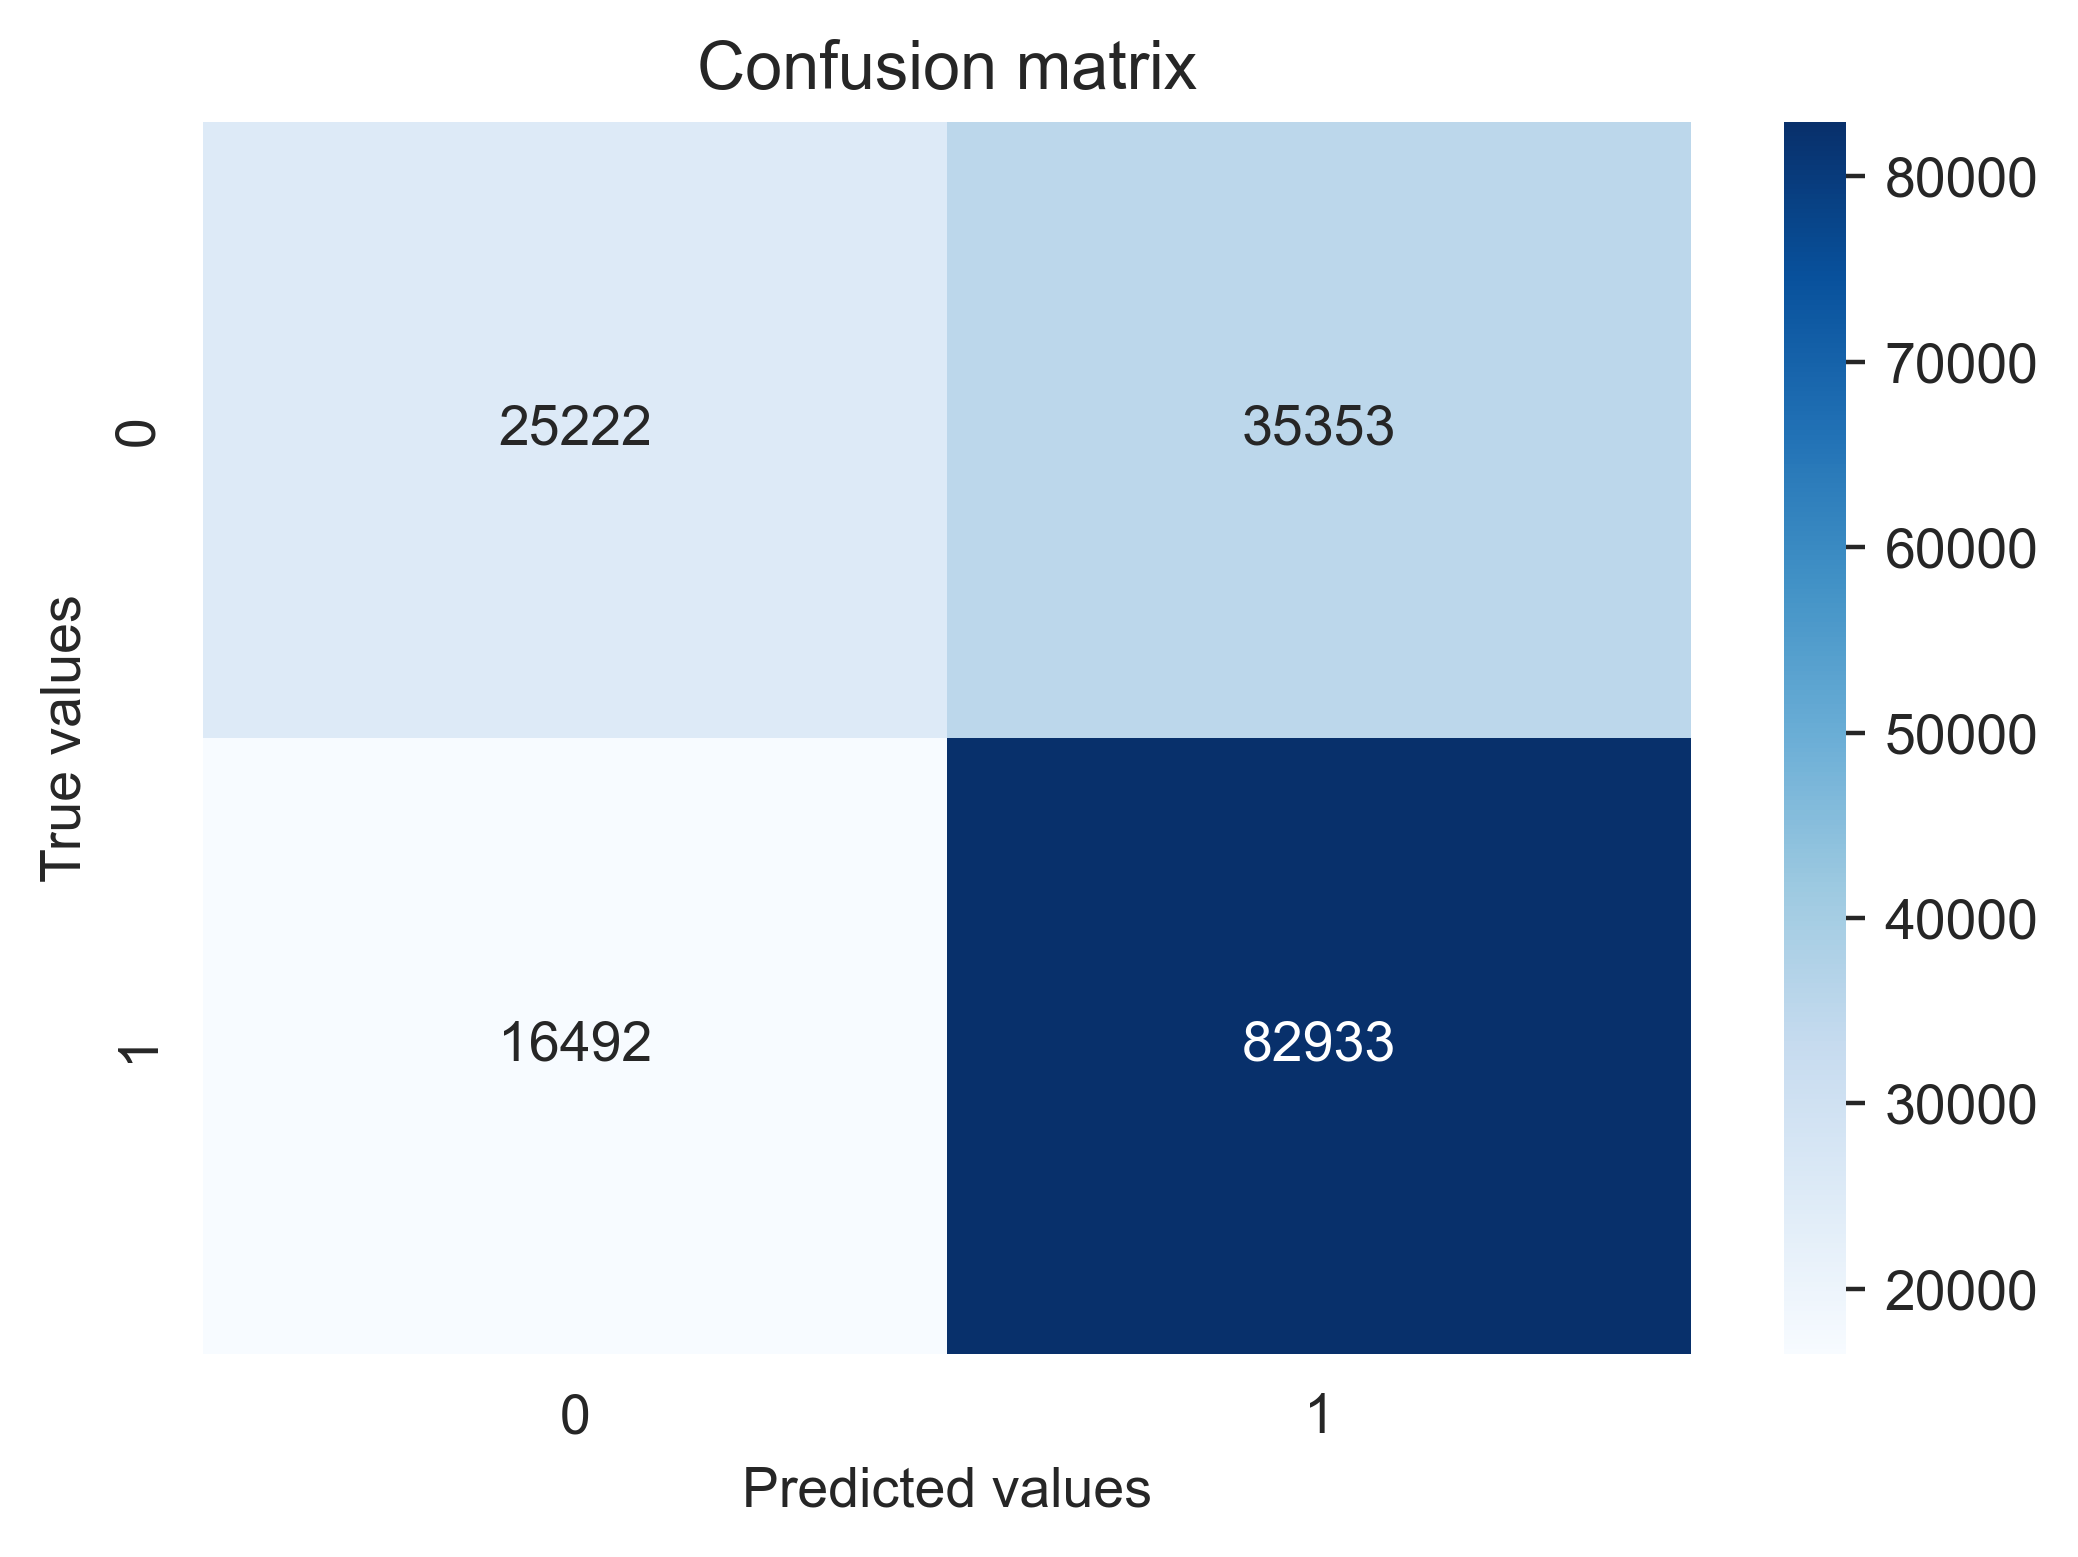

In [29]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [30]:
cat_probs = cat_model.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(y_test, cat_probs)
print(f"LGBMClassifier AUC Score: {cat_auc:.4f}")

LGBMClassifier AUC Score: 0.7154


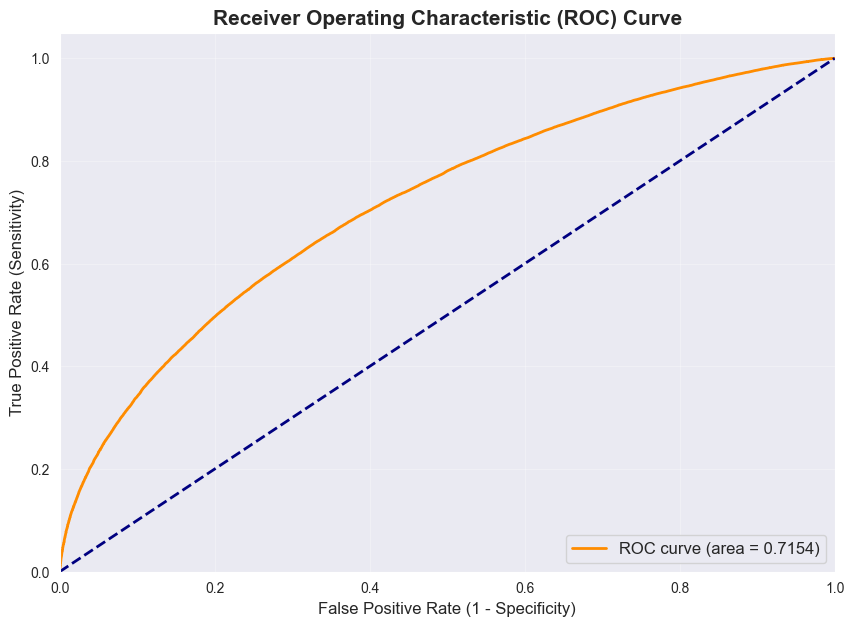

In [31]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, cat_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# Final Model

In [32]:
results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'LogisticRegression', 'CatBoostClassifier'],
    'AUC Score': [xgb_auc, lgbm_auc, lr_auc, cat_auc]
}).sort_values(by='AUC Score', ascending=False)

results

,Model,AUC Score
3,CatBoostClassifier,0.715428
1,LightGBM,0.714850
0,XGBoost,0.688967
2,LogisticRegression,0.688577
